In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import folium
import webbrowser as web
import geopandas as gpd
import scipy
import networkx as nx
import MAG as nxmag
import h3_util
from haversine import haversine, Unit
from folium import plugins

In [2]:
base_date_start = '2022-07-11'
base_date_end = '2022-07-15'

In [3]:
dir = f"{base_date_start}_to_{base_date_end}"

<h3>Load Data</h3>

In [66]:
logs = pd.read_parquet(f"{dir}//logs.parquet").query(f"line_code == '203'")
logs['event_timestamp'] = pd.to_datetime(logs['event_timestamp'])
logs['hour'] = logs['event_timestamp'].dt.hour
logs['base_date'] = pd.to_datetime(logs['base_date'])
logs.query(f"base_date == '{base_date_start}' and not hour in [0,1,2,3,4]", inplace = True)
itineraries = pd.read_parquet(f"{dir}//itineraries.parquet")
itineraries['base_date'] = pd.to_datetime(itineraries['base_date'])
itineraries.query(f"base_date == '{base_date_start}'", inplace = True)
itineraries = itineraries.merge(
    logs[['line_code', 'itinerary_id']].drop_duplicates(),
    how = 'inner'
)
dim_bs = pd.read_parquet(f"{dir}//dim_bs.parquet")
dim_bs = dim_bs.merge(
    itineraries.dummy_id.drop_duplicates(), 
    how = 'inner'
)

selected_pairs = pd.read_parquet(f"{dir}//selected_pairs.parquet")

connections_t = [pd.read_parquet(f) for f in glob.glob(f"{dir}//output_t//{base_date_start}*.parquet")]
connections_t = pd.concat(connections_t, ignore_index = True)
connections_t['event_timestamp_u'] = pd.to_datetime(connections_t['event_timestamp_u'])
connections_t['event_timestamp_v'] = pd.to_datetime(connections_t['event_timestamp_v'])
connections_t['hour'] = connections_t['event_timestamp_v'].dt.hour
connections_t.query('not hour in [0,1,2,3,4]', inplace = True)

connections_vt = [pd.read_parquet(f) for f in glob.glob(f"{dir}//output_vt//{base_date_start}*.parquet")]
connections_vt = pd.concat(connections_vt, ignore_index = True)
connections_vt['event_timestamp_u'] = pd.to_datetime(connections_vt['event_timestamp_u'])
connections_vt['event_timestamp_v'] = pd.to_datetime(connections_vt['event_timestamp_v'])
connections_vt['hour'] = connections_vt['event_timestamp_v'].dt.hour
connections_vt.query('not hour in [0,1,2,3,4]', inplace = True)

connections_vt = connections_vt.merge(
    selected_pairs,
    how = 'inner'
)

<h3>Terminais Físicos</h3>

In [5]:
g = nx.DiGraph()

nodes = []
for index, row in dim_bs.iterrows():
    nodes.append((row[0], dict(row[1:])))

g.add_nodes_from(nodes) 

In [6]:
# Arestas da rede estática
edges = []
for line_code, line_group in itineraries.groupby('line_code'):
    n = len(itineraries.query(f"line_code == '{line_code}'").itinerary_id.unique())
    for itinerary_id, itinerary_group in line_group.groupby('itinerary_id'):
        points = list(itineraries.query(f"line_code == '{line_code}' and itinerary_id == {itinerary_id}").sort_values(by = 'seq').dummy_id.to_numpy())
        if n == 1:
            points.append(points[0])        
        for i in range(0, len(points) - 1):
            attr = {'weight': haversine((g.nodes[points[i]]['latitude'], g.nodes[points[i]]['longitude']), (g.nodes[points[i + 1]]['latitude'], g.nodes[points[i + 1]]['longitude']), unit = Unit.METERS),
                   'line_code': line_code, 'itinerary_id': itinerary_id}
            edges.append((points[i], points[i + 1], attr)) 
g.add_edges_from(edges)             

In [7]:
nx.write_gexf(g, "curitiba.gexf")

In [9]:
degree = nx.degree_centrality(g)
closeness = nx.closeness_centrality(g, distance = 'weight')
betweenness = nx.betweenness_centrality(g, weight = 'weight')

In [10]:
centralities = pd.DataFrame(
    list(degree.items()), 
    columns=['dummy_id', 'degree']
).merge(
    pd.DataFrame(
        list(closeness.items()), 
        columns=['dummy_id', 'closeness']
    )
).merge(
    pd.DataFrame(
        list(betweenness.items()), 
        columns=['dummy_id', 'betweenness']
    )
).merge(
    dim_bs[['dummy_id', 'name_norm', 'type_norm']]
)

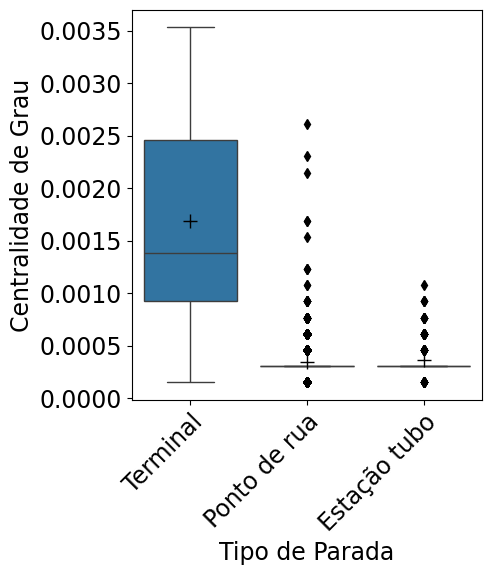

In [11]:
fig, axes = plt.subplots(figsize = (5, 6))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(
    x = centralities.type_norm, 
    y = centralities.degree, 
    linewidth = 1.0, hue = centralities.type_norm, 
    palette = sns.color_palette("tab10", 3), 
    notch = False, 
    order = ['Terminal', 'Ponto de rua', 'Estação tubo'], 
    hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo'], 
    ax = axes, flierprops = flierprops, meanprops = meanprops,
    showmeans = True
)
g.tick_params(labelsize = 17)
g.set_xlabel("Tipo de Parada", fontsize = 17)
g.set_ylabel("Centralidade de Grau", fontsize = 17)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.3, top=0.95)
fig.savefig('static_degree.png', format='png', dpi=300)

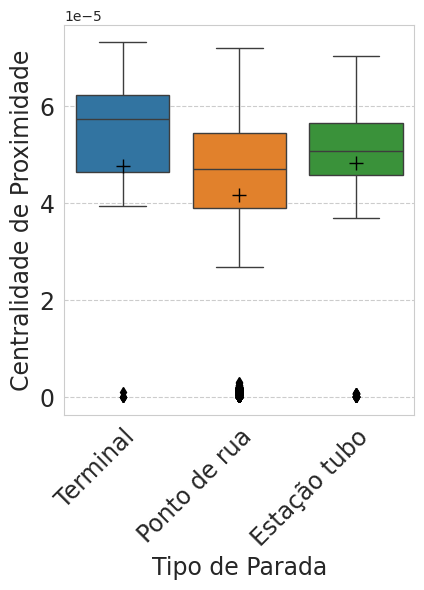

In [12]:
fig, axes = plt.subplots(figsize = (5, 6))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(
    x = centralities.type_norm, 
    y = centralities.closeness, 
    linewidth = 1.0, hue = centralities.type_norm, 
    palette = sns.color_palette("tab10", 3), 
    notch = False, 
    order = ['Terminal', 'Ponto de rua', 'Estação tubo'], 
    hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo'], 
    ax = axes, flierprops = flierprops, meanprops = meanprops,
    showmeans = True
)
g.tick_params(labelsize = 17)
g.set_xlabel("Tipo de Parada", fontsize = 17)
g.set_ylabel("Centralidade de Proximidade", fontsize = 17)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.3, top=0.95)
fig.savefig('static_closeness.png', format='png', dpi=300)

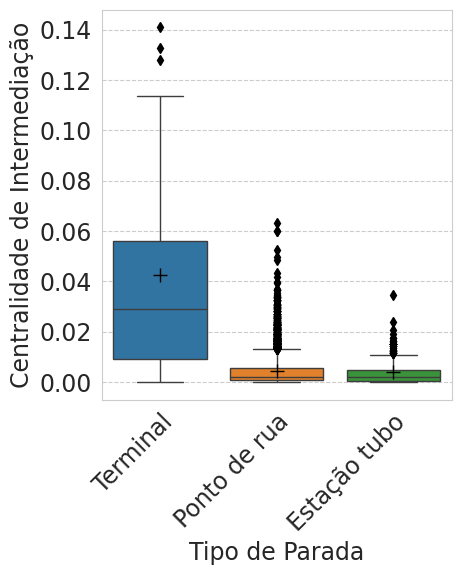

In [13]:
fig, axes = plt.subplots(figsize = (5, 6))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(
    x = centralities.type_norm, 
    y = centralities.betweenness, 
    linewidth = 1.0, hue = centralities.type_norm, 
    palette = sns.color_palette("tab10", 3), 
    notch = False, 
    order = ['Terminal', 'Ponto de rua', 'Estação tubo'], 
    hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo'], 
    ax = axes, flierprops = flierprops, meanprops = meanprops,
    showmeans = True
)
g.tick_params(labelsize = 17)
g.set_xlabel("Tipo de Parada", fontsize = 17)
g.set_ylabel("Centralidade de Intermediação", fontsize = 17)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.3, top=0.95)
fig.savefig('static_betweenness.png', format='png', dpi=300)

In [14]:
centralities.sort_values('betweenness', ascending = False).head(30)

,dummy_id,degree,closeness,betweenness,name_norm,type_norm
13,6277.0,0.003377,0.000071,0.140860,Terminal Capão Raso,Terminal
24,6288.0,0.002763,0.000073,0.132746,Terminal Portão,Terminal
23,6287.0,0.003224,0.000062,0.128014,Terminal Pinheirinho,Terminal
10,6274.0,0.002917,0.000071,0.113507,Terminal Campina do Siqueira,Terminal
19,6283.0,0.002917,0.000067,0.093757,Terminal Hauer,Terminal
7,6271.0,0.003224,0.000059,0.068142,Terminal Cabral,Terminal
570,110218.0,0.001689,0.000064,0.063285,"Alameda Dr. Muricy, 701 - Centro",Ponto de rua
405,110004.0,0.001228,0.000066,0.059822,"Rua Mal. Deodoro, 314 - Centro",Ponto de rua
404,110003.0,0.000921,0.000067,0.059817,"Rua Mal. Deodoro, 527 - Centro",Ponto de rua
14,6278.0,0.002303,0.000059,0.056414,Terminal Carmo,Terminal


<h3>Terminais Virtuais</h3>

In [15]:
vt_nodes_line_code = set(
    selected_pairs[[
        'cluster', 
        'cluster_name', 
        'dummy_id_u',
        'line_code_u'
    ]].itertuples(
        index = False, name = None)
).union(
    set(
        selected_pairs[[
            'cluster', 
            'cluster_name', 
            'dummy_id_v',
            'line_code_v'
        ]].itertuples(
            index = False, name = None)
    )
)

In [16]:
vt_nodes_line_code = pd.DataFrame(
    vt_nodes_line_code,
    columns = ['cluster', 'cluster_name', 'dummy_id', 'line_code']
)
vt_nodes_line_code['dummy_id_vt'] = vt_nodes_line_code.groupby('cluster').ngroup()

In [17]:
itineraries_vt = itineraries.merge(
    vt_nodes_line_code[['dummy_id', 'line_code', 'dummy_id_vt']],
    how = 'left'
)
itineraries_vt['dummy_id'] = np.where(
    itineraries_vt.dummy_id_vt.isna(), 
    itineraries_vt.dummy_id, 
    itineraries_vt.dummy_id_vt
)
itineraries_vt.drop(
    columns = 'dummy_id_vt',
    inplace = True
)

In [18]:
vt_nodes = dim_bs.merge(
    vt_nodes_line_code[['dummy_id', 'dummy_id_vt', 'cluster', 'cluster_name']].drop_duplicates(),
    how = 'inner'
)
vt_nodes['dummy_id_vt'] = np.where(
    vt_nodes['dummy_id_vt'].isna(), 
    vt_nodes.dummy_id,
    vt_nodes.dummy_id_vt
)
vt_nodes['name_norm'] = np.where(
    vt_nodes['cluster'].isna(), 
    vt_nodes.name_norm,
    vt_nodes['cluster_name']
)
vt_nodes['type_norm'] = np.where(
    vt_nodes['cluster'].isna(), 
    vt_nodes.type_norm,
    'Terminal virtual'
)

In [19]:
vt_nodes = vt_nodes.groupby(by = ['dummy_id_vt', 'name_norm', 'type_norm']).agg(
    {
        'latitude': 'mean',
        'longitude': 'mean'
    }
).reset_index().rename(columns = {'dummy_id_vt': 'dummy_id'})

In [20]:
bairro_map = h3_util.load_bairro_data('bairros.csv')
dim_bs_vt = pd.concat([dim_bs, vt_nodes], ignore_index = True)
dim_bs_vt['neighborhood'] = dim_bs_vt.apply(
    lambda x: h3_util.get_bairro_from_h3(
        h3_util.lat_lng_to_h3(x.latitude, x.longitude, 10), 
        bairro_map,
        x.name_norm
    ), axis = 1
)

In [21]:
g_vt = nx.DiGraph()

nodes = []
for index, row in dim_bs_vt.iterrows():
    nodes.append((row[0], dict(row[1:])))

g_vt.add_nodes_from(nodes) 

In [22]:
# Arestas da rede estática
edges = []
for line_code, line_group in itineraries_vt.groupby('line_code'):
    n = len(itineraries_vt.query(f"line_code == '{line_code}'").itinerary_id.unique())
    for itinerary_id, itinerary_group in line_group.groupby('itinerary_id'):
        points = list(itineraries_vt.query(f"line_code == '{line_code}' and itinerary_id == {itinerary_id}").sort_values(by = 'seq').dummy_id.to_numpy())
        if n == 1:
            points.append(points[0])        
        for i in range(0, len(points) - 1):
            attr = {'weight': haversine((g_vt.nodes[points[i]]['latitude'], g_vt.nodes[points[i]]['longitude']), (g_vt.nodes[points[i + 1]]['latitude'], g_vt.nodes[points[i + 1]]['longitude']), unit = Unit.METERS),
                   'line_code': line_code, 'itinerary_id': itinerary_id}
            edges.append((points[i], points[i + 1], attr)) 
#for idx, row in selected_pairs.iterrows():
#    try:
#        attr = {'weight': haversine((g_vt.nodes[row['dummy_id_u']]['latitude'], g_vt.nodes[row['dummy_id_u']]['longitude']), (g_vt.nodes[row['dummy_id_v']]['latitude'], g_vt.nodes[row['dummy_id_v']]['longitude']), unit = Unit.METERS),
#                       'line_code': row['cluster_name'], 'itinerary_id': 'integração'}
#        edges.append((row['dummy_id_u'], row['dummy_id_v'], attr))
#    except:
#        print(f"{row['dummy_id_u']} -> {row['dummy_id_v']}")

g_vt.add_edges_from(edges)             

In [23]:
nx.write_gexf(g_vt, "curitiba_vt.gexf")

In [24]:
degree_vt = nx.degree_centrality(g_vt)
closeness_vt = nx.closeness_centrality(g_vt, distance = 'weight')
betweenness_vt = nx.betweenness_centrality(g_vt, weight = 'weight')

In [25]:
centralities_vt = pd.DataFrame(
    list(degree_vt.items()), 
    columns=['dummy_id', 'degree']
).merge(
    pd.DataFrame(
        list(closeness_vt.items()), 
        columns=['dummy_id', 'closeness']
    )
).merge(
    pd.DataFrame(
        list(betweenness_vt.items()), 
        columns=['dummy_id', 'betweenness']
    )
).merge(
    dim_bs_vt[['dummy_id', 'name_norm', 'type_norm']]
)

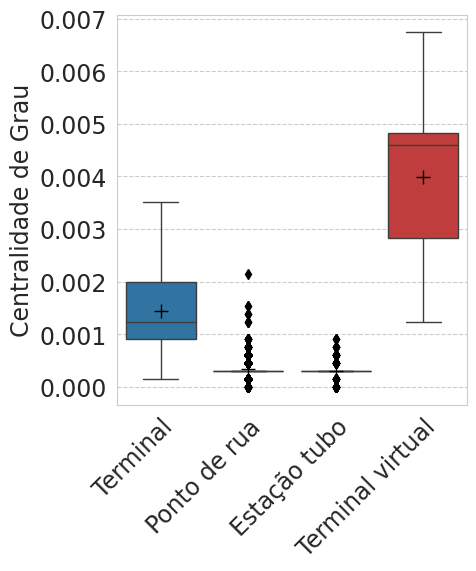

In [26]:
fig, axes = plt.subplots(figsize = (5, 6))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(
    x = centralities_vt.type_norm, 
    y = centralities_vt.degree, 
    linewidth = 1.0, hue = centralities_vt.type_norm, 
    palette = sns.color_palette("tab10", 4), 
    notch = False, 
    order = ['Terminal', 'Ponto de rua', 'Estação tubo', 'Terminal virtual'], 
    hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo', 'Terminal virtual'], 
    ax = axes, flierprops = flierprops, meanprops = meanprops,
    showmeans = True
)
g.tick_params(labelsize = 17)
g.set_xlabel(None)
g.set_ylabel("Centralidade de Grau", fontsize = 17)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.3, top=0.95)
fig.savefig('vt_degree.png', format='png', dpi=300)

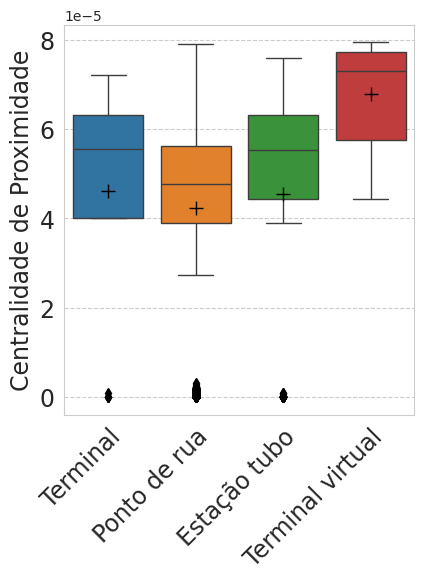

In [27]:
fig, axes = plt.subplots(figsize = (5, 6))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(
    x = centralities_vt.type_norm, 
    y = centralities_vt.closeness, 
    linewidth = 1.0, hue = centralities_vt.type_norm, 
    palette = sns.color_palette("tab10", 4), 
    notch = False, 
    order = ['Terminal', 'Ponto de rua', 'Estação tubo', 'Terminal virtual'], 
    hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo', 'Terminal virtual'], 
    ax = axes, flierprops = flierprops, meanprops = meanprops,
    showmeans = True
)
g.tick_params(labelsize = 17)
g.set_xlabel(None)
g.set_ylabel("Centralidade de Proximidade", fontsize = 17)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.3, top=0.95)
fig.savefig('vt_closeness.png', format='png', dpi=300)

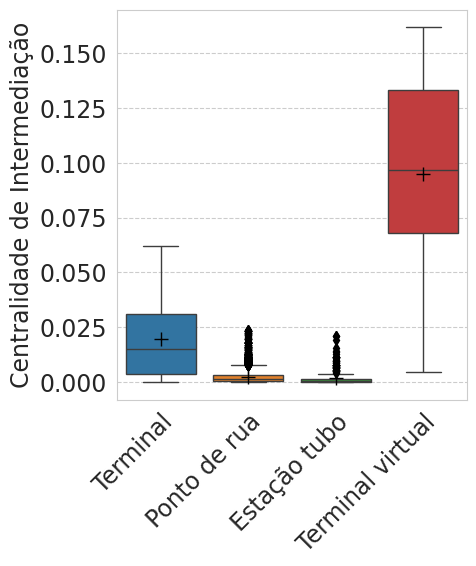

In [28]:
fig, axes = plt.subplots(figsize = (5, 6))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(
    x = centralities_vt.type_norm, 
    y = centralities_vt.betweenness, 
    linewidth = 1.0, hue = centralities_vt.type_norm, 
    palette = sns.color_palette("tab10", 4), 
    notch = False, 
    order = ['Terminal', 'Ponto de rua', 'Estação tubo', 'Terminal virtual'], 
    hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo', 'Terminal virtual'], 
    ax = axes, flierprops = flierprops, meanprops = meanprops,
    showmeans = True
)
g.tick_params(labelsize = 17)
g.set_xlabel(None)
g.set_ylabel("Centralidade de Intermediação", fontsize = 17)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.3, top=0.95)
fig.savefig('vt_betweenness.png', format='png', dpi=300)

In [29]:
centralities_vt.sort_values('betweenness', ascending = False).head(30)

,dummy_id,degree,closeness,betweenness,name_norm,type_norm
6525,10.0,0.006739,0.000072,0.161851,Centro Cívico,Terminal virtual
6521,6.0,0.005514,0.000073,0.147962,Novo Mundo,Terminal virtual
6527,12.0,0.004901,0.000077,0.146988,Centro,Terminal virtual
6528,13.0,0.004748,0.000078,0.142167,Centro,Terminal virtual
6519,4.0,0.004595,0.000075,0.124720,Novo Mundo,Terminal virtual
6524,9.0,0.003216,0.000079,0.120370,Centro,Terminal virtual
6520,5.0,0.004748,0.000079,0.109235,Batel,Terminal virtual
6529,14.0,0.004748,0.000077,0.096868,Prado Velho,Terminal virtual
6523,8.0,0.005820,0.000054,0.094365,Sítio Cercado,Terminal virtual
6518,3.0,0.004595,0.000079,0.093894,Rebouças,Terminal virtual


<h3>MAG</h3>

In [67]:
mag_log = logs[['dummy_id', 'line_code', 'vehicle', 'event_timestamp']].drop_duplicates().copy()
mag_log['ts'] = mag_log['event_timestamp'].dt.hour * 3600 + mag_log['event_timestamp'].dt.minute * 60 + mag_log['event_timestamp'].dt.second
mag_log['tm'] = mag_log['event_timestamp'].dt.hour * 60 + mag_log['event_timestamp'].dt.minute
mag_log['th'] = mag_log['event_timestamp'].dt.hour
mag_log.drop(columns = 'event_timestamp', inplace = True)
mag_log.sort_values(['line_code', 'vehicle', 'ts'], inplace = True)

grouped = mag_log.groupby(['line_code', 'vehicle'])
mag_log['dummy_id_v'] = mag_log.dummy_id.shift(-1)
mag_log['line_code_v'] = mag_log.line_code.shift(-1)
mag_log['vehicle_v'] = mag_log.vehicle.shift(-1)
mag_log['ts_v'] = mag_log.ts.shift(-1)
mag_log['tm_v'] = mag_log.tm.shift(-1)
mag_log['th_v'] = mag_log.th.shift(-1)

mag_log.rename(
    columns = {
        'dummy_id': 'dummy_id_u',
        'line_code': 'line_code_u',
        'vehicle': 'vehicle_u',
        'ts': 'ts_u',
        'tm': 'tm_u',
        'th': 'th_u',
    },
    inplace = True
)

mag_log.query("not ((ts_u == ts_v and dummy_id_u != dummy_id_v) or (ts_u > ts_v))", inplace = True)

mag_log = mag_log.merge(
    dim_bs[['dummy_id', 'latitude', 'longitude', 'neighborhood']],
    left_on = 'dummy_id_u',
    right_on = 'dummy_id'
).merge(
    dim_bs[['dummy_id', 'latitude', 'longitude', 'neighborhood']],
    left_on = 'dummy_id_v',
    right_on = 'dummy_id'
).rename(
    columns = {
        'latitude_x': 'latitude_u',
        'longitude_x': 'longitude_u',
        'neighborhood_x': 'neighborhood_u',
        'latitude_y': 'latitude_v',
        'longitude_y': 'longitude_v',
        'neighborhood_y': 'neighborhood_v'
    }
).drop(
    columns = {
        'dummy_id_x',
        'dummy_id_y'
    }
)

mag_log['ds'] = mag_log.apply(
    lambda x: haversine(
        (x['latitude_u'], x['longitude_u']),
        (x['latitude_v'], x['longitude_v']),
        Unit.METERS
    ),
    axis = 1
)

mag_log['dts'] = (mag_log['ts_v'] - mag_log['ts_u']).astype(int)
mag_log['dtm'] = (mag_log['tm_v'] - mag_log['tm_u']).astype(int)
mag_log['dth'] = (mag_log['th_v'] - mag_log['th_u']).astype(int)

mag_log['dummy_id_u'] = mag_log.dummy_id_u.astype(int)
mag_log['ts_u'] = mag_log.ts_u.astype(int)
mag_log['tm_u'] = mag_log.tm_u.astype(int)
mag_log['th_u'] = mag_log.th_u.astype(int)

mag_log['dummy_id_v'] = mag_log.dummy_id_v.astype(int)
mag_log['ts_v'] = mag_log.ts_v.astype(int)
mag_log['tm_v'] = mag_log.tm_v.astype(int)
mag_log['th_v'] = mag_log.th_v.astype(int)

In [71]:
mag_log.head()

,dummy_id_u,line_code_u,vehicle_u,ts_u,tm_u,th_u,dummy_id_v,line_code_v,vehicle_v,ts_v,...,latitude_u,longitude_u,neighborhood_u,latitude_v,longitude_v,neighborhood_v,ds,dts,dtm,dth
0,6269,203,BD139,19221,320,5,108005,203,BD139,19455,...,-25.393358,-49.240908,BOA VISTA,-25.387903,-49.235215,BOA VISTA,833.590269,234,4,0
1,6269,203,BD139,26656,444,7,108005,203,BD139,26771,...,-25.393358,-49.240908,BOA VISTA,-25.387903,-49.235215,BOA VISTA,833.590269,115,2,0
2,6269,203,BD139,33756,562,9,108005,203,BD139,33961,...,-25.393358,-49.240908,BOA VISTA,-25.387903,-49.235215,BOA VISTA,833.590269,205,4,0
3,6269,203,BD139,41516,691,11,108005,203,BD139,41684,...,-25.393358,-49.240908,BOA VISTA,-25.387903,-49.235215,BOA VISTA,833.590269,168,3,0
4,6269,203,BD139,48531,808,13,108005,203,BD139,48704,...,-25.393358,-49.240908,BOA VISTA,-25.387903,-49.235215,BOA VISTA,833.590269,173,3,0


In [69]:
mag_t = connections_t[
    ['dummy_id_u', 'line_code_u', 'vehicle_u', 'event_timestamp_u', 
     'dummy_id_v', 'line_code_v', 'vehicle_v', 'event_timestamp_v']
].copy()

mag_t['ts_u'] = mag_t['event_timestamp_u'].dt.hour * 3600 + mag_t['event_timestamp_u'].dt.minute * 60 + mag_t['event_timestamp_u'].dt.second
mag_t['tm_u'] = mag_t['event_timestamp_u'].dt.hour * 60 + mag_t['event_timestamp_u'].dt.minute
mag_t['th_u'] = mag_t['event_timestamp_u'].dt.hour

mag_t['ts_v'] = mag_t['event_timestamp_v'].dt.hour * 3600 + mag_t['event_timestamp_v'].dt.minute * 60 + mag_t['event_timestamp_v'].dt.second
mag_t['tm_v'] = mag_t['event_timestamp_v'].dt.hour * 60 + mag_t['event_timestamp_v'].dt.minute
mag_t['th_v'] = mag_t['event_timestamp_v'].dt.hour

mag_t['dts'] = (mag_t['ts_v'] - mag_t['ts_u']).astype(int)
mag_t['dtm'] = (mag_t['tm_v'] - mag_t['tm_u']).astype(int)
mag_t['dth'] = (mag_t['th_v'] - mag_t['th_u']).astype(int)
mag_t.query("dts >= 30", inplace = True)

mag_t.drop(columns = ['event_timestamp_u', 'event_timestamp_v'], inplace = True)

mag_t = mag_t.merge(
    dim_bs[['dummy_id', 'latitude', 'longitude', 'neighborhood']],
    left_on = 'dummy_id_u',
    right_on = 'dummy_id'
).merge(
    dim_bs[['dummy_id', 'latitude', 'longitude', 'neighborhood']],
    left_on = 'dummy_id_v',
    right_on = 'dummy_id'
).rename(
    columns = {
        'latitude_x': 'latitude_u',
        'longitude_x': 'longitude_u',
        'neighborhood_x': 'neighborhood_u',
        'latitude_y': 'latitude_v',
        'longitude_y': 'longitude_v',
        'neighborhood_y': 'neighborhood_v'
    }
).drop(
    columns = {
        'dummy_id_x',
        'dummy_id_y'
    }
)

mag_t['ds'] = mag_t.apply(
    lambda x: haversine(
        (x['latitude_u'], x['longitude_u']),
        (x['latitude_v'], x['longitude_v']),
        Unit.METERS
    ),
    axis = 1
)

mag_t['dummy_id_u'] = mag_t.dummy_id_u.astype(int)
mag_t['ts_u'] = mag_t.ts_u.astype(int)
mag_t['tm_u'] = mag_t.tm_u.astype(int)
mag_t['th_u'] = mag_t.th_u.astype(int)

mag_t['dummy_id_v'] = mag_t.dummy_id_v.astype(int)
mag_t['ts_v'] = mag_t.ts_v.astype(int)
mag_t['tm_v'] = mag_t.tm_v.astype(int)
mag_t['th_v'] = mag_t.th_v.astype(int)

In [70]:
mag_t.head()

,dummy_id_u,line_code_u,vehicle_u,dummy_id_v,line_code_v,vehicle_v,ts_u,tm_u,th_u,ts_v,...,dts,dtm,dth,latitude_u,longitude_u,neighborhood_u,latitude_v,longitude_v,neighborhood_v,ds
0,6269,342,BI012,6269,200,BE715,63689,1061,17,64521,...,832,14,0,-25.393358,-49.240908,BOA VISTA,-25.393358,-49.240908,BOA VISTA,0.0
1,6269,342,BI012,6269,200,BE725,63689,1061,17,64216,...,527,9,0,-25.393358,-49.240908,BOA VISTA,-25.393358,-49.240908,BOA VISTA,0.0
2,6269,342,BI012,6269,200,BE723,63689,1061,17,64824,...,1135,19,1,-25.393358,-49.240908,BOA VISTA,-25.393358,-49.240908,BOA VISTA,0.0
3,6269,342,BI012,6269,200,BE706,63689,1061,17,63744,...,55,1,0,-25.393358,-49.240908,BOA VISTA,-25.393358,-49.240908,BOA VISTA,0.0
4,6269,342,BI012,6269,202,GE707,63689,1061,17,63748,...,59,1,0,-25.393358,-49.240908,BOA VISTA,-25.393358,-49.240908,BOA VISTA,0.0


In [72]:
mag_t = pd.concat([mag_log, mag_t], ignore_index = True)

In [73]:
mag_t[
    ['dummy_id_u', 'line_code_u', 'vehicle_u', 'neighborhood_u', 'ts_u', 'tm_u', 'th_u', 
     'dummy_id_v', 'line_code_v', 'vehicle_v', 'neighborhood_v', 'ts_v', 'tm_v', 'th_v',      
     'dts', 'dtm', 'dth', 'ds'
    ]
].to_parquet('mag_t.parquet')

In [74]:
mag_vt = connections_vt[
    ['dummy_id_u', 'line_code_u', 'vehicle_u', 'event_timestamp_u', 
     'dummy_id_v', 'line_code_v', 'vehicle_v', 'event_timestamp_v']
].copy()

mag_vt['ts_u'] = mag_vt['event_timestamp_u'].dt.hour * 3600 + mag_vt['event_timestamp_u'].dt.minute * 60 + mag_vt['event_timestamp_u'].dt.second
mag_vt['tm_u'] = mag_vt['event_timestamp_u'].dt.hour * 60 + mag_vt['event_timestamp_u'].dt.minute
mag_vt['th_u'] = mag_vt['event_timestamp_u'].dt.hour

mag_vt['ts_v'] = mag_vt['event_timestamp_v'].dt.hour * 3600 + mag_vt['event_timestamp_v'].dt.minute * 60 + mag_vt['event_timestamp_v'].dt.second
mag_vt['tm_v'] = mag_vt['event_timestamp_v'].dt.hour * 60 + mag_vt['event_timestamp_v'].dt.minute
mag_vt['th_v'] = mag_vt['event_timestamp_v'].dt.hour

mag_vt['dts'] = (mag_vt['ts_v'] - mag_vt['ts_u']).astype(int)
mag_vt['dtm'] = (mag_vt['tm_v'] - mag_vt['tm_u']).astype(int)
mag_vt['dth'] = (mag_vt['th_v'] - mag_vt['th_u']).astype(int)
mag_vt.query("dts >= 30", inplace = True)

mag_vt.drop(columns = ['event_timestamp_u', 'event_timestamp_v'], inplace = True)

mag_vt = mag_vt.merge(
    dim_bs[['dummy_id', 'latitude', 'longitude', 'neighborhood']],
    left_on = 'dummy_id_u',
    right_on = 'dummy_id'
).merge(
    dim_bs[['dummy_id', 'latitude', 'longitude', 'neighborhood']],
    left_on = 'dummy_id_v',
    right_on = 'dummy_id'
).rename(
    columns = {
        'latitude_x': 'latitude_u',
        'longitude_x': 'longitude_u',
        'neighborhood_x': 'neighborhood_u',
        'latitude_y': 'latitude_v',
        'longitude_y': 'longitude_v',
        'neighborhood_y': 'neighborhood_v'
    }
).drop(
    columns = {
        'dummy_id_x',
        'dummy_id_y'
    }
)

mag_vt['ds'] = mag_vt.apply(
    lambda x: haversine(
        (x['latitude_u'], x['longitude_u']),
        (x['latitude_v'], x['longitude_v']),
        Unit.METERS
    ),
    axis = 1
)

mag_vt['dummy_id_u'] = mag_vt.dummy_id_u.astype(int)
mag_vt['ts_u'] = mag_vt.ts_u.astype(int)
mag_vt['tm_u'] = mag_vt.tm_u.astype(int)
mag_vt['th_u'] = mag_vt.th_u.astype(int)

mag_vt['dummy_id_v'] = mag_vt.dummy_id_v.astype(int)
mag_vt['ts_v'] = mag_vt.ts_v.astype(int)
mag_vt['tm_v'] = mag_vt.tm_v.astype(int)
mag_vt['th_v'] = mag_vt.th_v.astype(int)

In [75]:
mag_vt.head()

,dummy_id_u,line_code_u,vehicle_u,dummy_id_v,line_code_v,vehicle_v,ts_u,tm_u,th_u,ts_v,...,dts,dtm,dth,latitude_u,longitude_u,neighborhood_u,latitude_v,longitude_v,neighborhood_v,ds
0,108023,200,BE729,108023,203,BE710,36171,602,10,36496,...,325,6,0,-25.429965,-49.267514,CENTRO,-25.429965,-49.267514,CENTRO,0.0
1,108023,200,BE729,108023,203,GE736,36171,602,10,36822,...,651,11,0,-25.429965,-49.267514,CENTRO,-25.429965,-49.267514,CENTRO,0.0
2,108023,200,BE729,108023,203,BE728,51872,864,14,52809,...,937,16,0,-25.429965,-49.267514,CENTRO,-25.429965,-49.267514,CENTRO,0.0
3,108023,200,BE729,108023,203,GE726,51872,864,14,51974,...,102,2,0,-25.429965,-49.267514,CENTRO,-25.429965,-49.267514,CENTRO,0.0
4,108023,200,BE729,108023,203,GE727,51872,864,14,52372,...,500,8,0,-25.429965,-49.267514,CENTRO,-25.429965,-49.267514,CENTRO,0.0


In [76]:
mag_vt = pd.concat([mag_log, mag_vt], ignore_index = True)

In [77]:
mag_vt[
    ['dummy_id_u', 'line_code_u', 'vehicle_u', 'neighborhood_u', 'ts_u', 'tm_u', 'th_u', 
     'dummy_id_v', 'line_code_v', 'vehicle_v', 'neighborhood_v', 'ts_v', 'tm_v', 'th_v',      
     'dts', 'dtm', 'dth', 'ds'
    ]
].to_parquet('mag_vt.parquet')